In [83]:
! pip install awswrangler scikit-learn plotly


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [84]:
import pandas as pd
import numpy as np
# from pycaret.time_series import *
import matplotlib.pyplot as plt
import awswrangler as wr
import boto3
# from pycaret import *
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold, cross_validate


In [85]:
boto3.setup_default_session(profile_name='aisha_younas_fellow_dssgx_24')
bucket = "dssgx-munich-2024-bavarian-forest"
raw_data_folder = "raw-data"
preprocessed_data_folder = "preprocessed_data"

In [86]:
def load_csv_files_from_aws_s3(path: str, **kwargs) -> pd.DataFrame:
    """Loads individual or multiple CSV files from an AWS S3 bucket.
    Args:
        path (str): The path to the CSV files on AWS S3.
        **kwargs: Additional arguments to pass to the read_csv function.
    Returns:
        pd.DataFrame: The DataFrame containing the data from the CSV files.
    """
    df = wr.s3.read_csv(path=path, **kwargs)
    return df
df = load_csv_files_from_aws_s3(
    path="s3://dssgx-munich-2024-bavarian-forest/preprocessed_data/joined_sensor_weather_visitorcenter_2016-2024.csv"
)
df.head()

c:\Users\workshop\.pyenv-win-venv\envs\bf_dssgx\lib\site-packages\awswrangler\s3\_read_text_core.py:115: DtypeWarning: Columns (98,99,100,101,109,110,111,112,113,114,115,116,117,119,120) have mixed types. Specify dtype option on import or set low_memory=False.
  df: pd.DataFrame = parser_func(f, **pandas_kwargs)


Time  Bayerisch Eisenstein IN  Bayerisch Eisenstein OUT  \
0  2016-01-01 00:00:00                      NaN                       NaN   
1  2016-01-01 01:00:00                      NaN                       NaN   
2  2016-01-01 02:00:00                      NaN                       NaN   
3  2016-01-01 03:00:00                      NaN                       NaN   
4  2016-01-01 04:00:00                      NaN                       NaN   

   Brechhäuslau IN  Brechhäuslau OUT  Deffernik IN  Deffernik OUT  \
0              NaN               NaN           NaN            NaN   
1              NaN               NaN           NaN            NaN   
2              NaN               NaN           NaN            NaN   
3              NaN               NaN           NaN            NaN   
4              NaN               NaN           NaN            NaN   

   Diensthüttenstraße IN  Diensthüttenstraße OUT  Felswandergebiet IN  ...  \
0                    NaN                     NaN                  NaN  ...   
1                    NaN                     NaN                  NaN  ...   
2                    NaN                     NaN                  NaN  ...   
3                    NaN                     NaN                  NaN  ...   
4                    NaN                     NaN                  NaN  ...   

   Racheldiensthuette_geoeffnet  Waldschmidthaus_geoeffnet  \
0                           NaN                        NaN   
1                           NaN                        NaN   
2                           NaN                        NaN   
3                           NaN                        NaN   
4                           NaN                        NaN   

   Falkensteinschutzhaus_geoeffnet  Schwellhaeusl_geoeffnet  Temperatur  \
0                              NaN                      NaN         NaN   
1                              NaN                      NaN         NaN   
2                              NaN                      NaN         NaN   
3                              NaN                      NaN         NaN   
4                              NaN                      NaN         NaN   

   Niederschlagsmenge  Schneehoehe  GS mit  GS max  Total  
0                 NaN          NaN     NaN     NaN    NaN  
1                 NaN          NaN     NaN     NaN    NaN  
2                 NaN          NaN     NaN     NaN    NaN  
3                 NaN          NaN     NaN     NaN    NaN  
4                 NaN          NaN     NaN     NaN    NaN  

[5 rows x 127 columns]

In [87]:
print(list(df.columns))


['Time', 'Bayerisch Eisenstein IN', 'Bayerisch Eisenstein OUT', 'Brechhäuslau IN', 'Brechhäuslau OUT', 'Deffernik IN', 'Deffernik OUT', 'Diensthüttenstraße IN', 'Diensthüttenstraße OUT', 'Felswandergebiet IN', 'Felswandergebiet OUT', 'Ferdinandsthal IN', 'Ferdinandsthal OUT', 'Fredenbrücke IN', 'Fredenbrücke OUT', 'Gfäll IN', 'Gfäll OUT', 'Gsenget IN', 'Gsenget OUT', 'Klingenbrunner Wald IN', 'Klingenbrunner Wald OUT', 'Klosterfilz IN', 'Klosterfilz OUT', 'Racheldiensthütte IN', 'Racheldiensthütte OUT', 'Sagwassersäge IN', 'Sagwassersäge OUT', 'Scheuereck IN', 'Scheuereck OUT', 'Schillerstraße IN', 'Schillerstraße OUT', 'Schwarzbachbrücke IN', 'Schwarzbachbrücke OUT', 'Falkenstein 2 OUT', 'Falkenstein 2 IN', 'Lusen 2 IN', 'Lusen 2 OUT', 'Lusen 3 IN', 'Lusen 3 OUT', 'Waldhausreibe IN', 'Waldhausreibe OUT', 'Waldspielgelände IN', 'Waldspielgelände OUT', 'Wistlberg IN', 'Wistlberg OUT', 'Bucina MERGED IN', 'Bucina MERGED OUT', 'Falkenstein 1 MERGED IN', 'Falkenstein 1 MERGED OUT', 'Lusen 

In [88]:
# Specify the columns to use
columns_to_use = [
'Time',  'Bayerisch Eisenstein IN',  'Bayerisch Eisenstein OUT',  'Brechhäuslau IN',  'Brechhäuslau OUT',  
'Deffernik IN',  'Deffernik OUT',  'Diensthüttenstraße IN',  'Diensthüttenstraße OUT',  'Felswandergebiet IN',  
'Felswandergebiet OUT',  'Ferdinandsthal IN',  'Ferdinandsthal OUT',  'Fredenbrücke IN',  'Fredenbrücke OUT',  
'Gfäll IN',  'Gfäll OUT',  'Gsenget IN',  'Gsenget OUT',  'Klingenbrunner Wald IN',  'Klingenbrunner Wald OUT',  
'Klosterfilz IN',  'Klosterfilz OUT',  'Racheldiensthütte IN',  'Racheldiensthütte OUT',  'Sagwassersäge IN',  
'Sagwassersäge OUT',  'Scheuereck IN',  'Scheuereck OUT',  'Schillerstraße IN',  'Schillerstraße OUT',  
'Schwarzbachbrücke IN',  'Schwarzbachbrücke OUT',  'Falkenstein 2 OUT',  'Falkenstein 2 IN',  'Lusen 2 IN',  
'Lusen 2 OUT',  'Lusen 3 IN',  'Lusen 3 OUT',  'Waldhausreibe IN',  'Waldhausreibe OUT',  'Waldspielgelände IN',  
'Waldspielgelände OUT',  'Wistlberg IN',  'Wistlberg OUT',  'Bucina MERGED IN',  'Bucina MERGED OUT',  
'Falkenstein 1 MERGED IN',  'Falkenstein 1 MERGED OUT',  'Lusen 1 MERGED IN',  'Lusen 1 MERGED OUT',  
'Trinkwassertalsperre MERGED IN',  'Trinkwassertalsperre MERGED OUT',  'working_sensors',  
'traffic_abs',  'sum_IN_abs',  'sum_OUT_abs',  'Temperature (°C)',  'Relative Humidity (%)',  
'Precipitation (mm)',  'Wind Speed (km/h)',  'Sunshine Duration (min)',  'Tag',  'Monat',  'Jahr',  
'Wochentag',  'Wochenende',  'Jahreszeit',  'Laubfärbung',  'Schulferien_Bayern',  'Schulferien_CZ',  
'Feiertag_Bayern',  'Feiertag_CZ',  'HEH_geoeffnet',  'HZW_geoeffnet',  'WGM_geoeffnet',  
'Lusenschutzhaus_geoeffnet',  'Racheldiensthuette_geoeffnet',  'Falkensteinschutzhaus_geoeffnet',  
'Schwellhaeusl_geoeffnet'
]


In [89]:
# Filter the dataframe to only include the specified columns
df = df[columns_to_use]

# Display the first few rows to ensure the data is loaded correctly
df.head()

Time  Bayerisch Eisenstein IN  Bayerisch Eisenstein OUT  \
0  2016-01-01 00:00:00                      NaN                       NaN   
1  2016-01-01 01:00:00                      NaN                       NaN   
2  2016-01-01 02:00:00                      NaN                       NaN   
3  2016-01-01 03:00:00                      NaN                       NaN   
4  2016-01-01 04:00:00                      NaN                       NaN   

   Brechhäuslau IN  Brechhäuslau OUT  Deffernik IN  Deffernik OUT  \
0              NaN               NaN           NaN            NaN   
1              NaN               NaN           NaN            NaN   
2              NaN               NaN           NaN            NaN   
3              NaN               NaN           NaN            NaN   
4              NaN               NaN           NaN            NaN   

   Diensthüttenstraße IN  Diensthüttenstraße OUT  Felswandergebiet IN  ...  \
0                    NaN                     NaN                  NaN  ...   
1                    NaN                     NaN                  NaN  ...   
2                    NaN                     NaN                  NaN  ...   
3                    NaN                     NaN                  NaN  ...   
4                    NaN                     NaN                  NaN  ...   

   Schulferien_CZ  Feiertag_Bayern  Feiertag_CZ  HEH_geoeffnet  HZW_geoeffnet  \
0             NaN              NaN          NaN            NaN            NaN   
1             NaN              NaN          NaN            NaN            NaN   
2             NaN              NaN          NaN            NaN            NaN   
3             NaN              NaN          NaN            NaN            NaN   
4             NaN              NaN          NaN            NaN            NaN   

   WGM_geoeffnet  Lusenschutzhaus_geoeffnet  Racheldiensthuette_geoeffnet  \
0            NaN                        NaN                           NaN   
1            NaN                        NaN                           NaN   
2            NaN                        NaN                           NaN   
3            NaN                        NaN                           NaN   
4            NaN                        NaN                           NaN   

   Falkensteinschutzhaus_geoeffnet  Schwellhaeusl_geoeffnet  
0                              NaN                      NaN  
1                              NaN                      NaN  
2                              NaN                      NaN  
3                              NaN                      NaN  
4                              NaN                      NaN  

[5 rows x 80 columns]

In [90]:
# CREATE NEW REGION VARIABLE

# Remove MERGED from column names with this unnecessary label
df.columns = df.columns.str.replace(' MERGED', '', regex=False)

# Create a dictionary for mapping
location_mapping = {
    'Bayerisch Eisenstein IN': 'Falkenstein-Schwellhäusl',
    'Bayerisch Eisenstein OUT': 'Falkenstein-Schwellhäusl', 
    'Brechhäuslau IN': 'Falkenstein-Schwellhäusl', 
    'Brechhäuslau OUT': 'Falkenstein-Schwellhäusl', 
    'Deffernik IN': 'Falkenstein-Schwellhäusl',
    'Deffernik OUT': 'Falkenstein-Schwellhäusl',
    'Falkenstein 1 IN': 'Nationalparkzentrum Falkenstein', 
    'Falkenstein 1 OUT': 'Nationalparkzentrum Falkenstein',
    'Falkenstein 2 IN': 'Nationalparkzentrum Falkenstein', 
    'Falkenstein 2 OUT': 'Nationalparkzentrum Falkenstein',
    'Ferdinandsthal IN': 'Falkenstein-Schwellhäusl', 
    'Ferdinandsthal OUT': 'Falkenstein-Schwellhäusl', 
    'Gsenget IN': 'Scheuereck-Schachten-Trinkwassertalsperre', 
    'Gsenget OUT': 'Scheuereck-Schachten-Trinkwassertalsperre', 
    'Scheuereck IN': 'Scheuereck-Schachten-Trinkwassertalsperre',
    'Scheuereck OUT': 'Scheuereck-Schachten-Trinkwassertalsperre', 
    'Schillerstraße IN': 'Falkenstein-Schwellhäusl', 
    'Schillerstraße OUT': 'Falkenstein-Schwellhäusl', 
    'Trinkwassertalsperre IN': 'Scheuereck-Schachten-Trinkwassertalsperre',
    'Trinkwassertalsperre OUT': 'Scheuereck-Schachten-Trinkwassertalsperre',
    'Bucina IN': 'Lusen-Mauth-Finsterau',
    'Bucina OUT': 'Lusen-Mauth-Finsterau', 
    'Diensthüttenstraße IN': 'Rachel-Spiegelau', 
    'Diensthüttenstraße OUT': 'Rachel-Spiegelau',
    'Felswandergebiet IN': 'Lusen-Mauth-Finsterau', 
    'Felswandergebiet OUT': 'Lusen-Mauth-Finsterau',
    'Fredenbrücke IN': 'Lusen-Mauth-Finsterau', 
    'Fredenbrücke OUT': 'Lusen-Mauth-Finsterau', 
    'Gfäll IN': 'Rachel-Spiegelau', 
    'Gfäll OUT': 'Rachel-Spiegelau', 
    'Klingenbrunner Wald IN': 'Rachel-Spiegelau', 
    'Klingenbrunner Wald OUT': 'Rachel-Spiegelau', 
    'Klosterfilz IN': 'Rachel-Spiegelau', 
    'Klosterfilz OUT': 'Rachel-Spiegelau',
    'Lusen 1 IN': 'Nationalparkzentrum Lusen', 
    'Lusen 1 OUT': 'Nationalparkzentrum Lusen', 
    'Lusen 2 IN': 'Nationalparkzentrum Lusen',
    'Lusen 2 OUT': 'Nationalparkzentrum Lusen', 
    'Lusen 3 IN': 'Nationalparkzentrum Lusen', 
    'Lusen 3 OUT': 'Nationalparkzentrum Lusen',
    'Racheldiensthütte IN': 'Rachel-Spiegelau', 
    'Racheldiensthütte OUT': 'Rachel-Spiegelau',
    'Schwarzbachbrücke IN': 'Lusen-Mauth-Finsterau', 
    'Schwarzbachbrücke OUT': 'Lusen-Mauth-Finsterau', 
    'Waldhausreibe IN': 'Lusen-Mauth-Finsterau', 
    'Waldhausreibe OUT': 'Lusen-Mauth-Finsterau', 
    'Waldspielgelände IN': 'Rachel-Spiegelau', 
    'Waldspielgelände OUT': 'Rachel-Spiegelau', 
    'Wistlberg IN': 'Lusen-Mauth-Finsterau', 
    'Wistlberg OUT': 'Lusen-Mauth-Finsterau', 
    'Sagwassersäge IN': 'Lusen-Mauth-Finsterau',
    'Sagwassersäge OUT': 'Lusen-Mauth-Finsterau'
}

# Extract unique regions
regions = set(location_mapping.values())

# Iterate over each region
for region in regions:
    # Filter the keys in location_mapping that belong to the current region
    region_in_columns = [col for col in location_mapping if location_mapping[col] == region and ' IN' in col]
    region_out_columns = [col for col in location_mapping if location_mapping[col] == region and ' OUT' in col]

    # Sum the values for all IN columns of the current region, while retaining NaN where all are NaN
    df[f'{region} IN'] = df[region_in_columns].sum(axis=1, min_count=1)
    
    # Sum the values for all OUT columns of the current region, while retaining NaN where all are NaN
    df[f'{region} OUT'] = df[region_out_columns].sum(axis=1, min_count=1)

# Display the updated DataFrame
df.tail()

# EXPLANATION OF LOOPING FUNCTION BELOW
#min_count=1 in sum():
#The sum(axis=1, min_count=1) method ensures that if all values being summed are NaN, the result will be NaN.
#If at least one value is not NaN, it will compute the sum, ignoring the NaN values.
#Explanation:
#min_count=1: This parameter in the sum() function specifies the minimum number of non-NaN values required to perform the summation. If the count of non-NaN values is less than min_count, the result will be NaN.
#Result: The DataFrame will have the new region columns that sum the sensors while retaining NaN if all sensors in a region are NaN for a given row.

Time  Bayerisch Eisenstein IN  Bayerisch Eisenstein OUT  \
78907  2024-12-31 19:00:00                      NaN                       NaN   
78908  2024-12-31 20:00:00                      NaN                       NaN   
78909  2024-12-31 21:00:00                      NaN                       NaN   
78910  2024-12-31 22:00:00                      NaN                       NaN   
78911  2024-12-31 23:00:00                      NaN                       NaN   

       Brechhäuslau IN  Brechhäuslau OUT  Deffernik IN  Deffernik OUT  \
78907              NaN               NaN           NaN            NaN   
78908              NaN               NaN           NaN            NaN   
78909              NaN               NaN           NaN            NaN   
78910              NaN               NaN           NaN            NaN   
78911              NaN               NaN           NaN            NaN   

       Diensthüttenstraße IN  Diensthüttenstraße OUT  Felswandergebiet IN  \
78907                    NaN                     NaN                  NaN   
78908                    NaN                     NaN                  NaN   
78909                    NaN                     NaN                  NaN   
78910                    NaN                     NaN                  NaN   
78911                    NaN                     NaN                  NaN   

       ...  Nationalparkzentrum Falkenstein IN  \
78907  ...                                 NaN   
78908  ...                                 NaN   
78909  ...                                 NaN   
78910  ...                                 NaN   
78911  ...                                 NaN   

       Nationalparkzentrum Falkenstein OUT  Lusen-Mauth-Finsterau IN  \
78907                                  NaN                       NaN   
78908                                  NaN                       NaN   
78909                                  NaN                       NaN   
78910                                  NaN                       NaN   
78911                                  NaN                       NaN   

       Lusen-Mauth-Finsterau OUT  Falkenstein-Schwellhäusl IN  \
78907                        NaN                          NaN   
78908                        NaN                          NaN   
78909                        NaN                          NaN   
78910                        NaN                          NaN   
78911                        NaN                          NaN   

       Falkenstein-Schwellhäusl OUT  Rachel-Spiegelau IN  \
78907                           NaN                  NaN   
78908                           NaN                  NaN   
78909                           NaN                  NaN   
78910                           NaN                  NaN   
78911                           NaN                  NaN   

       Rachel-Spiegelau OUT  Nationalparkzentrum Lusen IN  \
78907                   NaN                           NaN   
78908                   NaN                           NaN   
78909                   NaN                           NaN   
78910                   NaN                           NaN   
78911                   NaN                           NaN   

       Nationalparkzentrum Lusen OUT  
78907                            NaN  
78908                            NaN  
78909                            NaN  
78910                            NaN  
78911                            NaN  

[5 rows x 92 columns]

In [91]:
print(df.columns.tolist())

['Time', 'Bayerisch Eisenstein IN', 'Bayerisch Eisenstein OUT', 'Brechhäuslau IN', 'Brechhäuslau OUT', 'Deffernik IN', 'Deffernik OUT', 'Diensthüttenstraße IN', 'Diensthüttenstraße OUT', 'Felswandergebiet IN', 'Felswandergebiet OUT', 'Ferdinandsthal IN', 'Ferdinandsthal OUT', 'Fredenbrücke IN', 'Fredenbrücke OUT', 'Gfäll IN', 'Gfäll OUT', 'Gsenget IN', 'Gsenget OUT', 'Klingenbrunner Wald IN', 'Klingenbrunner Wald OUT', 'Klosterfilz IN', 'Klosterfilz OUT', 'Racheldiensthütte IN', 'Racheldiensthütte OUT', 'Sagwassersäge IN', 'Sagwassersäge OUT', 'Scheuereck IN', 'Scheuereck OUT', 'Schillerstraße IN', 'Schillerstraße OUT', 'Schwarzbachbrücke IN', 'Schwarzbachbrücke OUT', 'Falkenstein 2 OUT', 'Falkenstein 2 IN', 'Lusen 2 IN', 'Lusen 2 OUT', 'Lusen 3 IN', 'Lusen 3 OUT', 'Waldhausreibe IN', 'Waldhausreibe OUT', 'Waldspielgelände IN', 'Waldspielgelände OUT', 'Wistlberg IN', 'Wistlberg OUT', 'Bucina IN', 'Bucina OUT', 'Falkenstein 1 IN', 'Falkenstein 1 OUT', 'Lusen 1 IN', 'Lusen 1 OUT', 'Trink

In [92]:
def load_csv_files_from_aws_s3(path: str, **kwargs) -> pd.DataFrame:
    """Loads individual or multiple CSV files from an AWS S3 bucket.
    Args:
        path (str): The path to the CSV files on AWS S3.
        **kwargs: Additional arguments to pass to the read_csv function.
    Returns:
        pd.DataFrame: The DataFrame containing the data from the CSV files.
    """
    df = wr.s3.read_csv(path=path, **kwargs)
    return df
df_newfeatures = load_csv_files_from_aws_s3(
    path="s3://dssgx-munich-2024-bavarian-forest/preprocessed_data/holidays_deltaweather_features_df.csv"
)
df_newfeatures.head()

Unnamed: 0                 Time  Bayerisch Eisenstein IN  \
0           0  2017-01-01 00:00:00                      NaN   
1           1  2017-01-01 01:00:00                      NaN   
2           2  2017-01-01 02:00:00                      NaN   
3           3  2017-01-01 03:00:00                      NaN   
4           4  2017-01-01 04:00:00                      NaN   

   Bayerisch Eisenstein OUT  Brechhäuslau IN  Brechhäuslau OUT  Deffernik IN  \
0                       NaN            257.0             412.0           NaN   
1                       NaN              NaN               NaN           NaN   
2                       NaN              NaN               NaN           NaN   
3                       NaN              NaN               NaN           NaN   
4                       NaN              NaN               NaN           NaN   

   Deffernik OUT  Diensthüttenstraße IN  Diensthüttenstraße OUT  ...  GS max  \
0            NaN                    NaN                     NaN  ...   345.0   
1            NaN                    NaN                     NaN  ...   345.0   
2            NaN                    NaN                     NaN  ...   345.0   
3            NaN                    NaN                     NaN  ...   345.0   
4            NaN                    NaN                     NaN  ...   345.0   

   Total        Date  Distance_to_Nearest_Holiday_Bayern  \
0    1.0  2017-01-01                                   0   
1    1.0  2017-01-01                                   0   
2    1.0  2017-01-01                                   0   
3    1.0  2017-01-01                                   0   
4    1.0  2017-01-01                                   0   

   Distance_to_Nearest_Holiday_CZ  ZScore_Daily_Max_Temperature (°C)  \
0                               0                                NaN   
1                               0                                NaN   
2                               0                                NaN   
3                               0                                NaN   
4                               0                                NaN   

   ZScore_Daily_Max_Relative Humidity (%)  \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   

   ZScore_Daily_Max_Precipitation (mm)  ZScore_Daily_Max_Wind Speed (km/h)  \
0                                  NaN                                 NaN   
1                                  NaN                                 NaN   
2                                  NaN                                 NaN   
3                                  NaN                                 NaN   
4                                  NaN                                 NaN   

   ZScore_Daily_Max_Sunshine Duration (min)  
0                                       NaN  
1                                       NaN  
2                                       NaN  
3                                       NaN  
4                                       NaN  

[5 rows x 136 columns]

In [93]:
df['Time'] = pd.to_datetime(df['Time'])
df_newfeatures['Time'] = pd.to_datetime(df_newfeatures['Time'])

# Step 2: Select the columns you want to add from df_newfeatures
columns_to_add = [
    'ZScore_Daily_Max_Temperature (°C)',
    'ZScore_Daily_Max_Relative Humidity (%)',
    'ZScore_Daily_Max_Precipitation (mm)',
    'ZScore_Daily_Max_Wind Speed (km/h)',
    'ZScore_Daily_Max_Sunshine Duration (min)',
    'Distance_to_Nearest_Holiday_Bayern',
    'Distance_to_Nearest_Holiday_CZ'
]

# Ensure that the selected columns exist in df_newfeatures
selected_columns = [col for col in columns_to_add if col in df_newfeatures.columns]

# Step 3: Merge df with df_newfeatures on 'Time' and add the selected columns
df = pd.merge(df, df_newfeatures[['Time'] + selected_columns], on='Time', how='left')

# Optionally, you can display the merged dataframe
df.head()

Time  Bayerisch Eisenstein IN  Bayerisch Eisenstein OUT  \
0 2016-01-01 00:00:00                      NaN                       NaN   
1 2016-01-01 01:00:00                      NaN                       NaN   
2 2016-01-01 02:00:00                      NaN                       NaN   
3 2016-01-01 03:00:00                      NaN                       NaN   
4 2016-01-01 04:00:00                      NaN                       NaN   

   Brechhäuslau IN  Brechhäuslau OUT  Deffernik IN  Deffernik OUT  \
0              NaN               NaN           NaN            NaN   
1              NaN               NaN           NaN            NaN   
2              NaN               NaN           NaN            NaN   
3              NaN               NaN           NaN            NaN   
4              NaN               NaN           NaN            NaN   

   Diensthüttenstraße IN  Diensthüttenstraße OUT  Felswandergebiet IN  ...  \
0                    NaN                     NaN                  NaN  ...   
1                    NaN                     NaN                  NaN  ...   
2                    NaN                     NaN                  NaN  ...   
3                    NaN                     NaN                  NaN  ...   
4                    NaN                     NaN                  NaN  ...   

   Rachel-Spiegelau OUT  Nationalparkzentrum Lusen IN  \
0                   NaN                           NaN   
1                   NaN                           NaN   
2                   NaN                           NaN   
3                   NaN                           NaN   
4                   NaN                           NaN   

   Nationalparkzentrum Lusen OUT  ZScore_Daily_Max_Temperature (°C)  \
0                            NaN                                NaN   
1                            NaN                                NaN   
2                            NaN                                NaN   
3                            NaN                                NaN   
4                            NaN                                NaN   

   ZScore_Daily_Max_Relative Humidity (%)  \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   

   ZScore_Daily_Max_Precipitation (mm)  ZScore_Daily_Max_Wind Speed (km/h)  \
0                                  NaN                                 NaN   
1                                  NaN                                 NaN   
2                                  NaN                                 NaN   
3                                  NaN                                 NaN   
4                                  NaN                                 NaN   

   ZScore_Daily_Max_Sunshine Duration (min)  \
0                                       NaN   
1                                       NaN   
2                                       NaN   
3                                       NaN   
4                                       NaN   

   Distance_to_Nearest_Holiday_Bayern  Distance_to_Nearest_Holiday_CZ  
0                                 NaN                             NaN  
1                                 NaN                             NaN  
2                                 NaN                             NaN  
3                                 NaN                             NaN  
4                                 NaN                             NaN  

[5 rows x 99 columns]

In [94]:
df['Time'] = pd.to_datetime(df['Time'])  # Convert to datetime if in columns
df.set_index('Time', inplace=True)
df["Hour"] = df.index.hour  # Now this will work

# Specify the data types
dtype_dict = {
    'Time': 'datetime64[ns]',
    'traffic_abs': 'float64',
    'Temperature (°C)': 'float64',
    'Relative Humidity (%)': 'float64',
    'Precipitation (mm)': 'float64',
    'Wind Speed (km/h)': 'float64',
    'Sunshine Duration (min)': 'float64',
    'Monat': 'float64',
    'Wochentag': 'category',
    'Wochenende': 'category',
    'Jahreszeit': 'category',
    'Laubfärbung': 'category',
    'Feiertag_Bayern': 'category',
    'Feiertag_CZ': 'category',
    'HEH_geoeffnet': 'category',
    'HZW_geoeffnet': 'category',
    'WGM_geoeffnet': 'category',
    'Lusenschutzhaus_geoeffnet': 'category',
    'Racheldiensthuette_geoeffnet': 'category',
    'Falkensteinschutzhaus_geoeffnet': 'category',
    'Schwellhaeusl_geoeffnet': 'category',
    'Schulferien_Bayern': 'category',
    'Schulferien_CZ': 'category',
    'Jahr': 'float64',
    'working_sensors': 'float64',
    'sum_IN_abs': 'float64',
    'sum_OUT_abs': 'float64',
    'Falkenstein-Schwellhäusl IN': 'float64',
    'Rachel-Spiegelau IN': 'float64',
    'Nationalparkzentrum Falkenstein IN': 'float64',
    'Nationalparkzentrum Lusen IN': 'float64',
    'Lusen-Mauth-Finsterau IN': 'float64',
    'Scheuereck-Schachten-Trinkwassertalsperre IN': 'float64',
    'Falkenstein-Schwellhäusl OUT': 'float64',
    'Rachel-Spiegelau OUT': 'float64',
    'Nationalparkzentrum Falkenstein OUT': 'float64',
    'Nationalparkzentrum Lusen OUT': 'float64',
    'Lusen-Mauth-Finsterau OUT': 'float64',
    'Scheuereck-Schachten-Trinkwassertalsperre OUT': 'float64',
    'Bayerisch Eisenstein IN': 'float64',
    'Bayerisch Eisenstein OUT': 'float64',
    'Brechhäuslau IN': 'float64',
    'Brechhäuslau OUT': 'float64',
    'Deffernik IN': 'float64',
    'Deffernik OUT': 'float64',
    'Diensthüttenstraße IN': 'float64',
    'Diensthüttenstraße OUT': 'float64',
    'Felswandergebiet IN': 'float64',
    'Felswandergebiet OUT': 'float64',
    'Ferdinandsthal IN': 'float64',
    'Ferdinandsthal OUT': 'float64',
    'Fredenbrücke IN': 'float64',
    'Fredenbrücke OUT': 'float64',
    'Gfäll IN': 'float64',
    'Gfäll OUT': 'float64',
    'Gsenget IN': 'float64',
    'Gsenget OUT': 'float64',
    'Klingenbrunner Wald IN': 'float64',
    'Klingenbrunner Wald OUT': 'float64',
    'Klosterfilz IN': 'float64',
    'Klosterfilz OUT': 'float64',
    'Racheldiensthütte IN': 'float64',
    'Racheldiensthütte OUT': 'float64',
    'Sagwassersäge IN': 'float64',
    'Sagwassersäge OUT': 'float64',
    'Scheuereck IN': 'float64',
    'Scheuereck OUT': 'float64',
    'Schillerstraße IN': 'float64',
    'Schillerstraße OUT': 'float64',
    'Schwarzbachbrücke IN': 'float64',
    'Schwarzbachbrücke OUT': 'float64',
    'Falkenstein 2 OUT': 'float64',
    'Falkenstein 2 IN': 'float64',
    'Lusen 2 IN': 'float64',
    'Lusen 2 OUT': 'float64',
    'Lusen 3 IN': 'float64',
    'Lusen 3 OUT': 'float64',
    'Waldhausreibe IN': 'float64',
    'Waldhausreibe OUT': 'float64',
    'Waldspielgelände IN': 'float64',
    'Waldspielgelände OUT': 'float64',
    'Wistlberg IN': 'float64',
    'Wistlberg OUT': 'float64',
    'Bucina IN': 'float64',
    'Bucina OUT': 'float64',
    'Falkenstein 1 IN': 'float64',
    'Falkenstein 1 OUT': 'float64',
    'Lusen 1 IN': 'float64',
    'Lusen 1 OUT': 'float64',
    'Trinkwassertalsperre IN': 'float64',
    'Trinkwassertalsperre OUT': 'float64',
    'ZScore_Daily_Max_Temperature (°C)': 'float64',
    'ZScore_Daily_Max_Relative Humidity (%)': 'float64',
    'ZScore_Daily_Max_Precipitation (mm)': 'float64',
    'ZScore_Daily_Max_Wind Speed (km/h)': 'float64',
    'ZScore_Daily_Max_Sunshine Duration (min)': 'float64',
    'Distance_to_Nearest_Holiday_Bayern': 'float64',
    'Distance_to_Nearest_Holiday_CZ': 'float64',
    'Hour': 'category'
}

# Show the dataframe
print(df.head())


                     Bayerisch Eisenstein IN  Bayerisch Eisenstein OUT  \
Time                                                                     
2016-01-01 00:00:00                      NaN                       NaN   
2016-01-01 01:00:00                      NaN                       NaN   
2016-01-01 02:00:00                      NaN                       NaN   
2016-01-01 03:00:00                      NaN                       NaN   
2016-01-01 04:00:00                      NaN                       NaN   

                     Brechhäuslau IN  Brechhäuslau OUT  Deffernik IN  \
Time                                                                   
2016-01-01 00:00:00              NaN               NaN           NaN   
2016-01-01 01:00:00              NaN               NaN           NaN   
2016-01-01 02:00:00              NaN               NaN           NaN   
2016-01-01 03:00:00              NaN               NaN           NaN   
2016-01-01 04:00:00              NaN             

In [95]:
# Slice the data from January 1, 2023, to August 19, 2024
df = df.loc['2023-01-01':'2024-08-19']
# Display the info to check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14328 entries, 2023-01-01 00:00:00 to 2024-08-19 23:00:00
Data columns (total 99 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Bayerisch Eisenstein IN                        14050 non-null  float64
 1   Bayerisch Eisenstein OUT                       14050 non-null  float64
 2   Brechhäuslau IN                                14049 non-null  float64
 3   Brechhäuslau OUT                               14049 non-null  float64
 4   Deffernik IN                                   13773 non-null  float64
 5   Deffernik OUT                                  13773 non-null  float64
 6   Diensthüttenstraße IN                          13906 non-null  float64
 7   Diensthüttenstraße OUT                         13906 non-null  float64
 8   Felswandergebiet IN                            13643 non-null  float64
 9   Felswandergebie

In [96]:
df.tail()

Bayerisch Eisenstein IN  Bayerisch Eisenstein OUT  \
Time                                                                     
2024-08-19 19:00:00                      NaN                       NaN   
2024-08-19 20:00:00                      NaN                       NaN   
2024-08-19 21:00:00                      NaN                       NaN   
2024-08-19 22:00:00                      NaN                       NaN   
2024-08-19 23:00:00                      NaN                       NaN   

                     Brechhäuslau IN  Brechhäuslau OUT  Deffernik IN  \
Time                                                                   
2024-08-19 19:00:00              NaN               NaN           NaN   
2024-08-19 20:00:00              NaN               NaN           NaN   
2024-08-19 21:00:00              NaN               NaN           NaN   
2024-08-19 22:00:00              NaN               NaN           NaN   
2024-08-19 23:00:00              NaN               NaN           NaN   

                     Deffernik OUT  Diensthüttenstraße IN  \
Time                                                        
2024-08-19 19:00:00            NaN                    NaN   
2024-08-19 20:00:00            NaN                    NaN   
2024-08-19 21:00:00            NaN                    NaN   
2024-08-19 22:00:00            NaN                    NaN   
2024-08-19 23:00:00            NaN                    NaN   

                     Diensthüttenstraße OUT  Felswandergebiet IN  \
Time                                                               
2024-08-19 19:00:00                     NaN                  NaN   
2024-08-19 20:00:00                     NaN                  NaN   
2024-08-19 21:00:00                     NaN                  NaN   
2024-08-19 22:00:00                     NaN                  NaN   
2024-08-19 23:00:00                     NaN                  NaN   

                     Felswandergebiet OUT  ...  Nationalparkzentrum Lusen IN  \
Time                                       ...                                 
2024-08-19 19:00:00                   NaN  ...                           0.0   
2024-08-19 20:00:00                   NaN  ...                           1.0   
2024-08-19 21:00:00                   NaN  ...                           0.0   
2024-08-19 22:00:00                   NaN  ...                           0.0   
2024-08-19 23:00:00                   NaN  ...                           0.0   

                     Nationalparkzentrum Lusen OUT  \
Time                                                 
2024-08-19 19:00:00                           12.0   
2024-08-19 20:00:00                            4.0   
2024-08-19 21:00:00                            0.0   
2024-08-19 22:00:00                            0.0   
2024-08-19 23:00:00                            0.0   

                     ZScore_Daily_Max_Temperature (°C)  \
Time                                                     
2024-08-19 19:00:00                          -0.489326   
2024-08-19 20:00:00                          -0.489326   
2024-08-19 21:00:00                          -0.489326   
2024-08-19 22:00:00                          -0.489326   
2024-08-19 23:00:00                          -0.489326   

                     ZScore_Daily_Max_Relative Humidity (%)  \
Time                                                          
2024-08-19 19:00:00                                0.535474   
2024-08-19 20:00:00                                0.535474   
2024-08-19 21:00:00                                0.535474   
2024-08-19 22:00:00                                0.535474   
2024-08-19 23:00:00                                0.535474   

                     ZScore_Daily_Max_Precipitation (mm)  \
Time                                                       
2024-08-19 19:00:00                            -0.065137   
2024-08-19 20:00:00                            -0.065137   
2024-08-19 21:00:00                            -0.065137   
202

In [97]:
region_columns = [
    'Falkenstein-Schwellhäusl IN', 
    'Rachel-Spiegelau IN', 
    'Nationalparkzentrum Falkenstein IN',
    'Nationalparkzentrum Lusen IN', 
    'Lusen-Mauth-Finsterau IN', 
    'Scheuereck-Schachten-Trinkwassertalsperre IN',
    'Falkenstein-Schwellhäusl OUT', 
    'Rachel-Spiegelau OUT', 
    'Nationalparkzentrum Falkenstein OUT',
    'Nationalparkzentrum Lusen OUT', 
    'Lusen-Mauth-Finsterau OUT', 
    'Scheuereck-Schachten-Trinkwassertalsperre OUT'
]

for column in region_columns:
    if column in df.columns:
        missing_dates = df[df[column].isna()].index
        if not missing_dates.empty:
            first_missing_date = missing_dates[0]
            print(f"Column '{column}' has its first missing value on {first_missing_date}")
        else:
            print(f"Column '{column}' has no missing values")
    else:
        print(f"Column '{column}' is not in the DataFrame")


Column 'Falkenstein-Schwellhäusl IN' has its first missing value on 2024-08-08 11:00:00
Column 'Rachel-Spiegelau IN' has its first missing value on 2024-08-07 14:00:00
Column 'Nationalparkzentrum Falkenstein IN' has no missing values
Column 'Nationalparkzentrum Lusen IN' has no missing values
Column 'Lusen-Mauth-Finsterau IN' has its first missing value on 2024-07-23 00:00:00
Column 'Scheuereck-Schachten-Trinkwassertalsperre IN' has its first missing value on 2024-08-06 18:00:00
Column 'Falkenstein-Schwellhäusl OUT' has its first missing value on 2024-08-08 11:00:00
Column 'Rachel-Spiegelau OUT' has its first missing value on 2024-08-07 14:00:00
Column 'Nationalparkzentrum Falkenstein OUT' has no missing values
Column 'Nationalparkzentrum Lusen OUT' has no missing values
Column 'Lusen-Mauth-Finsterau OUT' has its first missing value on 2024-07-23 00:00:00
Column 'Scheuereck-Schachten-Trinkwassertalsperre OUT' has its first missing value on 2024-08-06 18:00:00


In [98]:
# Slice the data from January 1, 2023, to July 22, 2024
df = df.loc['2023-01-01':'2024-07-22']
# Display the info to check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13656 entries, 2023-01-01 00:00:00 to 2024-07-22 23:00:00
Data columns (total 99 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Bayerisch Eisenstein IN                        13656 non-null  float64
 1   Bayerisch Eisenstein OUT                       13656 non-null  float64
 2   Brechhäuslau IN                                13656 non-null  float64
 3   Brechhäuslau OUT                               13656 non-null  float64
 4   Deffernik IN                                   13379 non-null  float64
 5   Deffernik OUT                                  13379 non-null  float64
 6   Diensthüttenstraße IN                          13656 non-null  float64
 7   Diensthüttenstraße OUT                         13656 non-null  float64
 8   Felswandergebiet IN                            13643 non-null  float64
 9   Felswandergebie

In [99]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

Deffernik IN                277
Deffernik OUT               277
Felswandergebiet IN          13
Felswandergebiet OUT         13
Fredenbrücke IN              13
Fredenbrücke OUT             13
Klingenbrunner Wald IN     1140
Klingenbrunner Wald OUT    1140
Sagwassersäge IN             13
Sagwassersäge OUT            13
Scheuereck IN               182
Scheuereck OUT              182
Schwarzbachbrücke IN         13
Schwarzbachbrücke OUT        13
Wistlberg IN                 35
Wistlberg OUT                35
Bucina IN                    12
Bucina OUT                   12
Lusen 1 IN                    3
Lusen 1 OUT                   3
dtype: int64


In [100]:
print(df.columns.tolist())

['Bayerisch Eisenstein IN', 'Bayerisch Eisenstein OUT', 'Brechhäuslau IN', 'Brechhäuslau OUT', 'Deffernik IN', 'Deffernik OUT', 'Diensthüttenstraße IN', 'Diensthüttenstraße OUT', 'Felswandergebiet IN', 'Felswandergebiet OUT', 'Ferdinandsthal IN', 'Ferdinandsthal OUT', 'Fredenbrücke IN', 'Fredenbrücke OUT', 'Gfäll IN', 'Gfäll OUT', 'Gsenget IN', 'Gsenget OUT', 'Klingenbrunner Wald IN', 'Klingenbrunner Wald OUT', 'Klosterfilz IN', 'Klosterfilz OUT', 'Racheldiensthütte IN', 'Racheldiensthütte OUT', 'Sagwassersäge IN', 'Sagwassersäge OUT', 'Scheuereck IN', 'Scheuereck OUT', 'Schillerstraße IN', 'Schillerstraße OUT', 'Schwarzbachbrücke IN', 'Schwarzbachbrücke OUT', 'Falkenstein 2 OUT', 'Falkenstein 2 IN', 'Lusen 2 IN', 'Lusen 2 OUT', 'Lusen 3 IN', 'Lusen 3 OUT', 'Waldhausreibe IN', 'Waldhausreibe OUT', 'Waldspielgelände IN', 'Waldspielgelände OUT', 'Wistlberg IN', 'Wistlberg OUT', 'Bucina IN', 'Bucina OUT', 'Falkenstein 1 IN', 'Falkenstein 1 OUT', 'Lusen 1 IN', 'Lusen 1 OUT', 'Trinkwasserta

In [101]:
# Create funtion for obtaining feature importances
def get_feature_names_after_encoding(preprocessor, numeric_features, categorical_features):
    # Get the transformer for the numeric features
    numeric_transformer = preprocessor.named_transformers_['num']
    
    # Get the transformer for the categorical features (OneHotEncoder)
    cat_transformer = preprocessor.named_transformers_['cat']
    
    # Get the feature names for numeric features (after scaling)
    numeric_feature_names = numeric_features
    
    # Get the feature names for categorical features (after one-hot encoding)
    cat_feature_names = cat_transformer.get_feature_names_out(categorical_features)
    
    # Combine all feature names
    feature_names = list(numeric_feature_names) + list(cat_feature_names)
    
    return feature_names


In [118]:
# Assuming df is your DataFrame with the data
# Define target and feature columns
target_vars = ['traffic_abs', 'sum_IN_abs', 'sum_OUT_abs', 'Lusen-Mauth-Finsterau IN', 'Lusen-Mauth-Finsterau OUT', 
               'Falkenstein-Schwellhäusl IN', 'Falkenstein-Schwellhäusl OUT', 'Rachel-Spiegelau IN', 
               'Rachel-Spiegelau OUT', 'Nationalparkzentrum Lusen IN', 'Nationalparkzentrum Lusen OUT', 
               'Scheuereck-Schachten-Trinkwassertalsperre IN', 'Scheuereck-Schachten-Trinkwassertalsperre OUT', 
               'Nationalparkzentrum Falkenstein IN', 'Nationalparkzentrum Falkenstein OUT']

numeric_features = ['Temperature (°C)', 'Relative Humidity (%)', 'Precipitation (mm)', 'Wind Speed (km/h)', 
                    'Sunshine Duration (min)', 'ZScore_Daily_Max_Temperature (°C)', 
                    'ZScore_Daily_Max_Relative Humidity (%)','ZScore_Daily_Max_Precipitation (mm)',
                    'ZScore_Daily_Max_Wind Speed (km/h)','ZScore_Daily_Max_Sunshine Duration (min)',
                    'Distance_to_Nearest_Holiday_Bayern','Distance_to_Nearest_Holiday_CZ']
categorical_features = ['Wochentag', 'Wochenende', 'Jahreszeit', 'Laubfärbung', 'Schulferien_Bayern', 
                        'Schulferien_CZ', 'Feiertag_Bayern', 'Feiertag_CZ', 'HEH_geoeffnet', 'HZW_geoeffnet', 'WGM_geoeffnet', 
                        'Lusenschutzhaus_geoeffnet', 'Racheldiensthuette_geoeffnet', 'Falkensteinschutzhaus_geoeffnet', 
                        'Schwellhaeusl_geoeffnet', ]

cyclic_features = ['Hour', 'Monat', 'Tag']

# Split the data into features and targets
X = df[numeric_features + categorical_features]
y = df[target_vars]



In [103]:
X.index

DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               ...
               '2024-07-22 14:00:00', '2024-07-22 15:00:00',
               '2024-07-22 16:00:00', '2024-07-22 17:00:00',
               '2024-07-22 18:00:00', '2024-07-22 19:00:00',
               '2024-07-22 20:00:00', '2024-07-22 21:00:00',
               '2024-07-22 22:00:00', '2024-07-22 23:00:00'],
              dtype='datetime64[ns]', name='Time', length=13656, freq=None)

# Model Traning

In [104]:
# Import libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
import numpy as np

In [105]:
# One-hot encode the categorical features
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
categorical_encoded = encoder.fit_transform(df[categorical_features])

In [106]:
# Standardize numeric features
scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(df[numeric_features])

In [107]:
# Combine numeric and categorical data
X_combined = np.concatenate([numeric_scaled, categorical_encoded], axis=1)

In [108]:
# Define target variables
y = df[target_vars].values

In [109]:
# Create sequences for LSTM
timesteps = 24  # Look-back period (adjust as needed)
def create_sequences(data, targets, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i + timesteps])
        y.append(targets[i + timesteps])
    return np.array(X), np.array(y)

X_seq, y_seq = create_sequences(X_combined, y, timesteps)

In [110]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

In [111]:
model = Sequential()
model.add(Input(shape=(X_seq.shape[1], X_seq.shape[2])))
model.add(Bidirectional(LSTM(128, return_sequences=True)))  # Bidirectional LSTM
model.add(Dropout(0.3))  # Increased dropout
model.add(Bidirectional(LSTM(128)))  # Bidirectional LSTM
model.add(Dropout(0.3))  # Increased dropout
model.add(Dense(64, activation='relu'))  # Dense layer
model.add(Dense(len(target_vars)))  # Output layer

In [112]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [113]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 7082.9575 - val_loss: 2739.2451
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 3823.6477 - val_loss: 1227.8749
Epoch 3/50
110/154 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 1475.5343

KeyboardInterrupt: 

In [79]:
# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2041.1902
Test Loss: 1745.010986328125


In [80]:
# Predict on test set
y_pred = model.predict(X_test)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


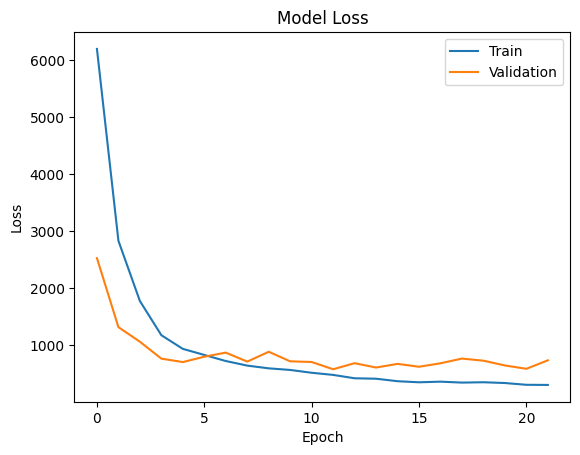

In [81]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [82]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2041.1902
Test Loss: 1745.010986328125


In [83]:
import pandas as pd

# Predict on the test set
y_pred = model.predict(X_test)

# Convert predictions and actual values to DataFrames for comparison
y_test_df = pd.DataFrame(y_test, columns=target_vars)
y_pred_df = pd.DataFrame(y_pred, columns=target_vars)

# Display first few rows of predictions vs. actual values
comparison_df = pd.concat([y_test_df.reset_index(drop=True), y_pred_df.reset_index(drop=True)], axis=1)
comparison_df.columns = [f'Actual_{col}' for col in target_vars] + [f'Predicted_{col}' for col in target_vars]
print(comparison_df.head())


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
   Actual_traffic_abs  Actual_sum_IN_abs  Actual_sum_OUT_abs  \
0               206.0              152.0                54.0   
1               457.0              308.0               149.0   
2               846.0              483.0               363.0   
3               942.0              475.0               467.0   
4              1056.0              508.0               548.0   

   Actual_Lusen-Mauth-Finsterau IN  Actual_Lusen-Mauth-Finsterau OUT  \
0                             61.0                              15.0   
1                             53.0                              29.0   
2                             71.0                              50.0   
3                             75.0                              75.0   
4                             66.0                             105.0   

   Actual_Falkenstein-Schwellhäusl IN  Actual_Falkenstein-Schwellhäusl OUT  \
0                                27.0                           

In [96]:
# Convert predictions and actual values to DataFrames
y_test_df = pd.DataFrame(y_test, columns=target_vars)
y_pred_df = pd.DataFrame(y_pred, columns=target_vars)

# Optionally, select a subset of variables to visualize
variables_to_plot = target_vars  # or specify a list like ['traffic_abs', 'sum_IN_abs']


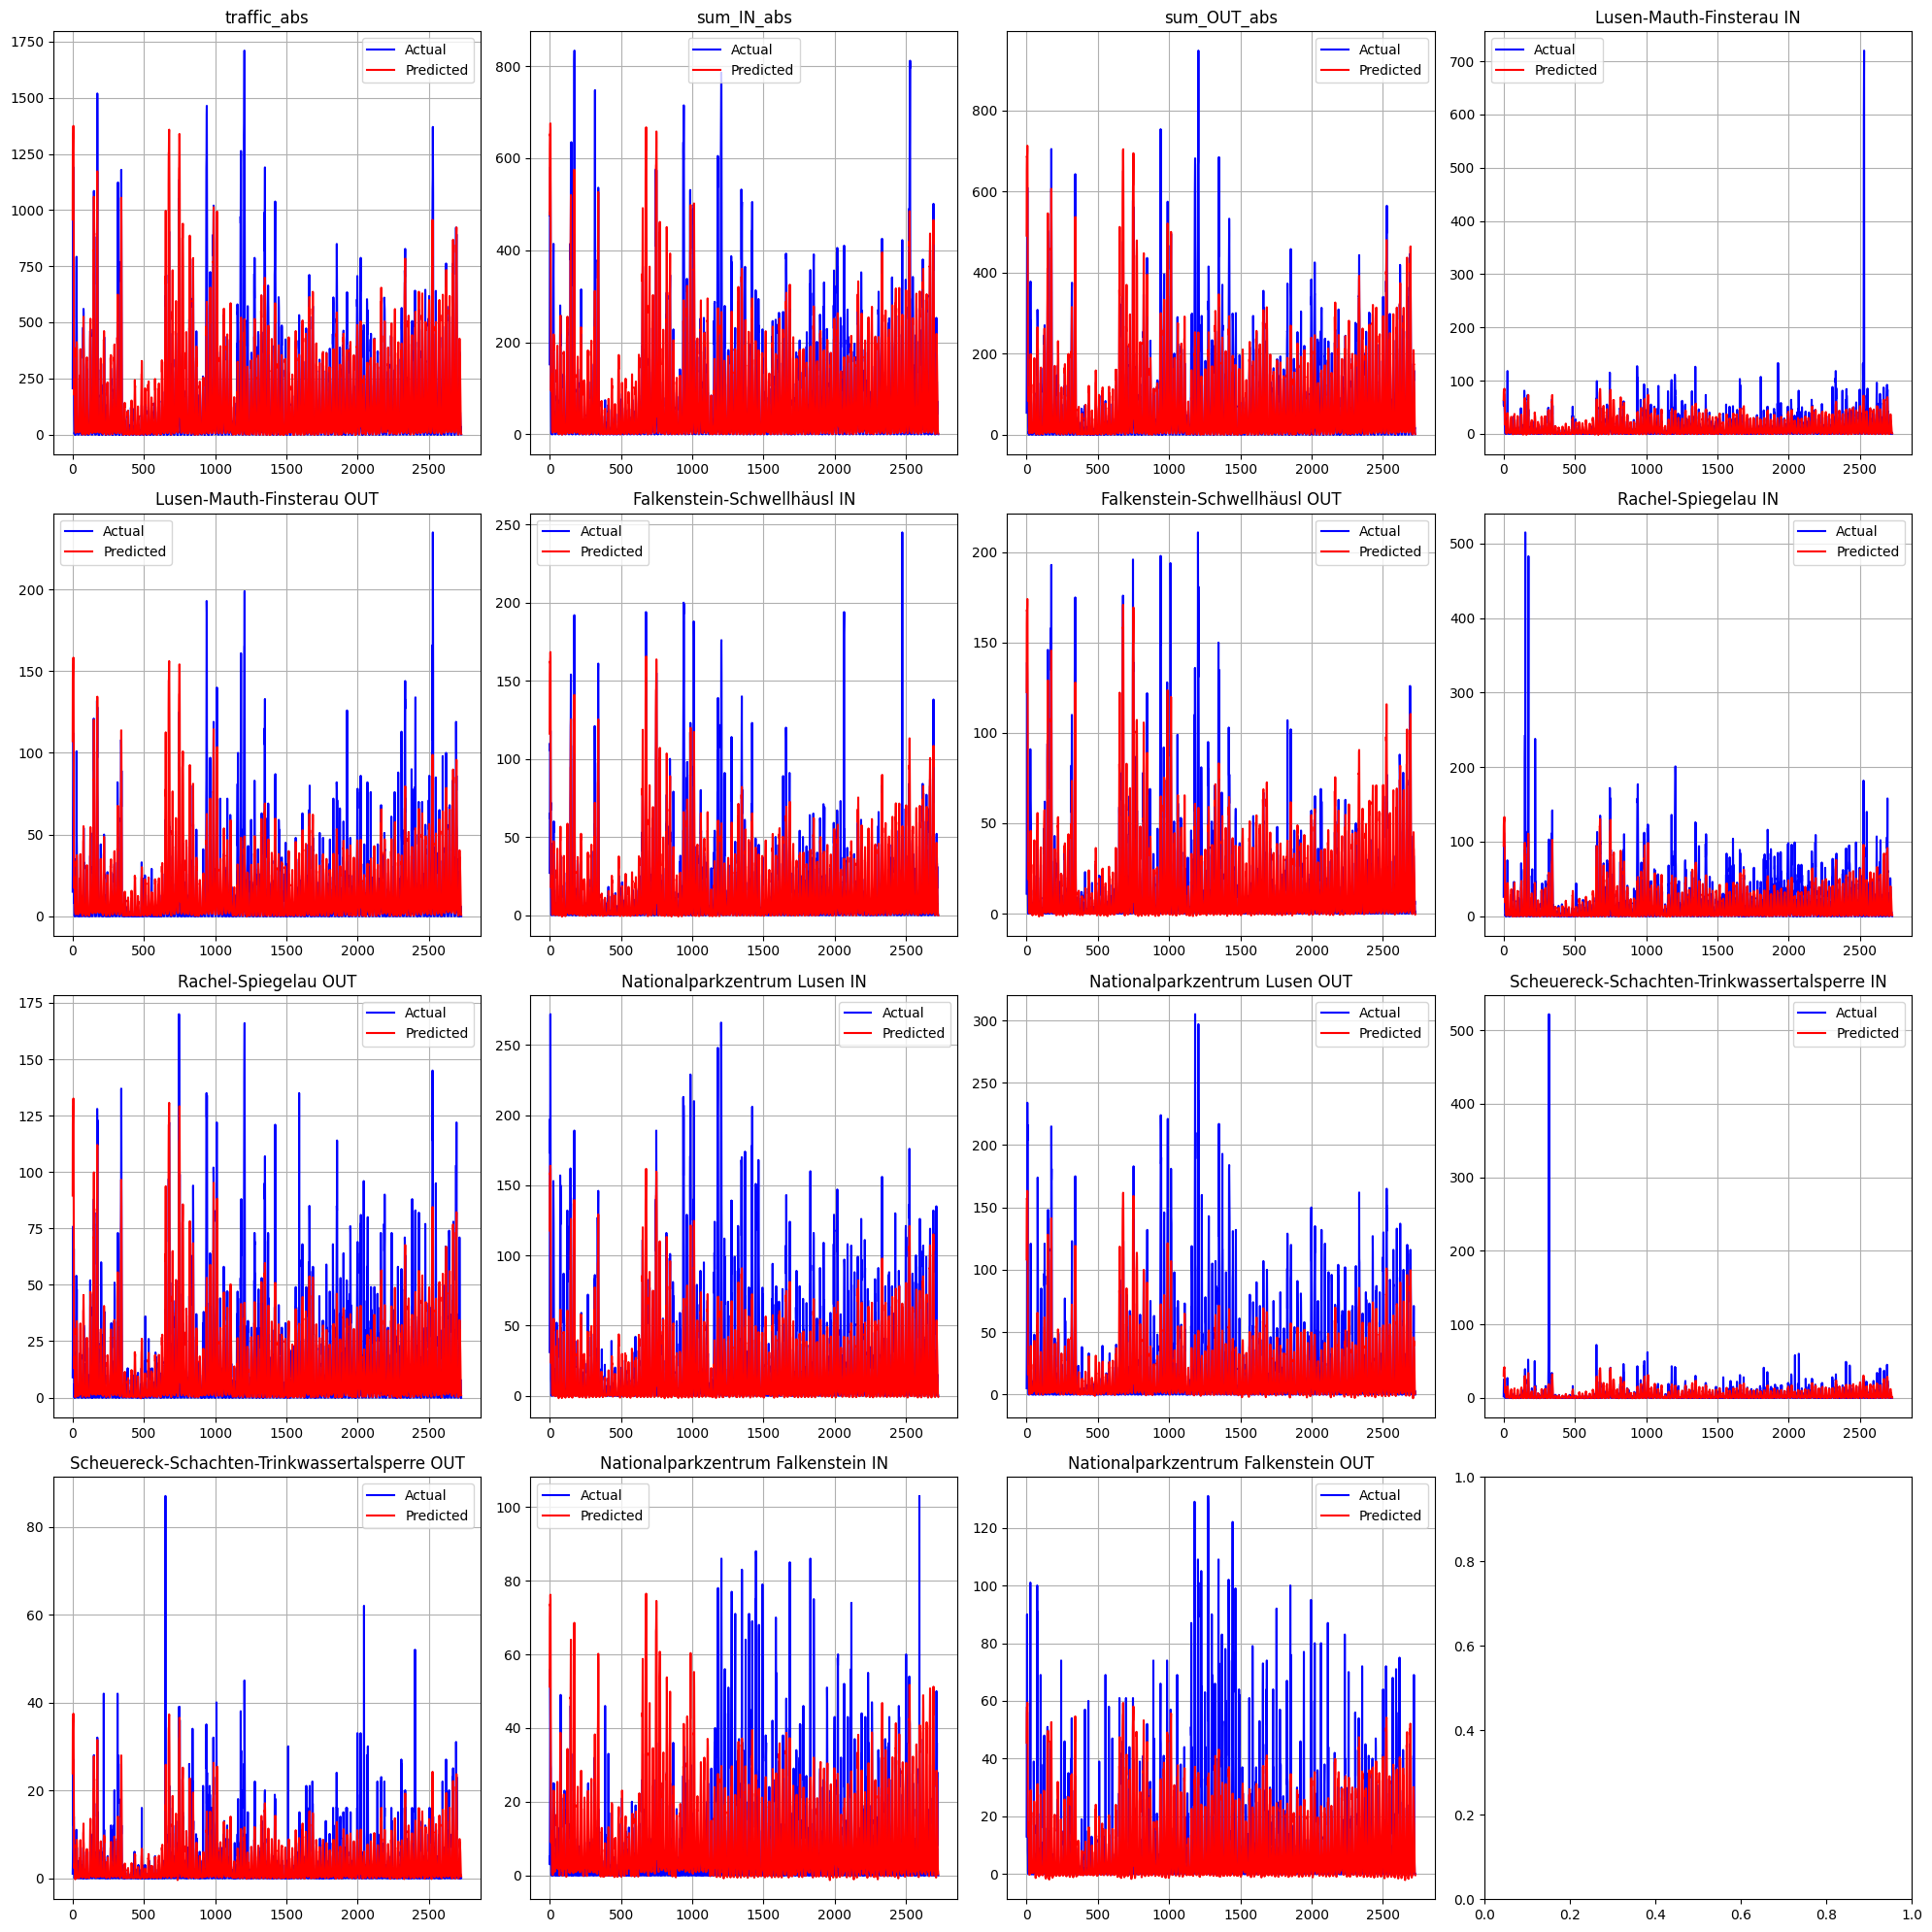

In [98]:
def plot_actual_vs_predicted(y_test_df, y_pred_df, variables, num_rows=4, num_cols=4):
    """
    Plot actual vs predicted values for specified target variables.
    """
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))
    axs = axs.flatten()
    
    for i, var in enumerate(variables):
        if i >= len(axs):  # Ensure we do not exceed available subplots
            break
        
        axs[i].plot(y_test_df.index, y_test_df[var], label='Actual', color='blue')
        axs[i].plot(y_test_df.index, y_pred_df[var], label='Predicted', color='red')
        axs[i].set_title(var)
        axs[i].legend()
        axs[i].grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot actual vs predicted values
plot_actual_vs_predicted(y_test_df, y_pred_df, variables_to_plot)


In [103]:
print(y_test_df.index)
print(y_pred_df.index)

print(y_test_df.index.dtype)
print(y_pred_df.index.dtype)

RangeIndex(start=0, stop=2727, step=1)
RangeIndex(start=0, stop=2727, step=1)
int64
int64


##  Model Iteration 2

In [122]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

def preprocess_data(df, numeric_features, categorical_features, cyclic_features):
    """
    Preprocess the data by normalizing numeric features, encoding categorical features, and handling cyclic features.
    
    Args:
    df (pd.DataFrame): The input dataframe.
    numeric_features (list): List of numeric feature column names.
    categorical_features (list): List of categorical feature column names.
    cyclic_features (list): List of features to be treated as cyclic.
    
    Returns:
    pd.DataFrame: The preprocessed features.
    """
    # Make a copy to avoid modifying the original DataFrame
    df_copy = df.copy()

    # Generate cyclic features
    for feature in cyclic_features:
        df_copy[f'{feature}_sin'] = np.sin(2 * np.pi * df_copy[feature] / df_copy[feature].max())
        df_copy[f'{feature}_cos'] = np.cos(2 * np.pi * df_copy[feature] / df_copy[feature].max())
    
    # Separate numeric features
    X_numeric = df_copy[numeric_features]
    
    # Separate categorical features (excluding cyclic ones)
    X_categorical = df_copy[categorical_features + [f'{f}_sin' for f in cyclic_features] + [f'{f}_cos' for f in cyclic_features]]
    
    # Normalize numeric features
    scaler = StandardScaler()
    X_numeric_scaled = scaler.fit_transform(X_numeric)
    
    # Encode categorical features
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    X_categorical_encoded = encoder.fit_transform(X_categorical)
    
    # Combine numeric and categorical features
    X = np.hstack([X_numeric_scaled, X_categorical_encoded])
    
    return X


In [123]:
def create_sequences(data, targets, sequence_length=24):
    """
    Create sequences of data for LSTM model.
    
    Args:
    data (np.array): The preprocessed feature data.
    targets (np.array): The target data.
    sequence_length (int): The length of the sequence.
    
    Returns:
    tuple: Arrays of sequences for X and y.
    """
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(targets[i + sequence_length])
    return np.array(X), np.array(y)

In [124]:
def build_lstm_model(input_shape, target_dim):
    """
    Build the LSTM model.
    
    Args:
    input_shape (tuple): The shape of the input data (timesteps, features).
    target_dim (int): The number of target variables.
    
    Returns:
    tf.keras.Model: The compiled LSTM model.
    """
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(target_dim))  # Output layer
    model.compile(optimizer='adam', loss='mse')
    return model

In [137]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_performance(y_true_df, y_pred_df):
    """
    Evaluate the performance of the model using MAPE, MAE, and RMSE.
    
    Parameters:
    y_true_df (pd.DataFrame): DataFrame with actual values.
    y_pred_df (pd.DataFrame): DataFrame with predicted values.
    
    Returns:
    pd.DataFrame: DataFrame containing the evaluation metrics for each target variable.
    """
    metrics = {}

    for col in y_true_df.columns:
        y_true = y_true_df[col]
        y_pred = y_pred_df[col]
        
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        
        metrics[col] = {
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape
        }
    
    metrics_df = pd.DataFrame(metrics).T
    return metrics_df


In [144]:
import plotly.graph_objects as go
import pandas as pd

def plot_actual_vs_predicted(y_test_df, y_pred_df, variables, date_index):
    """
    Plot actual vs predicted values for specified target variables using Plotly.
    
    Args:
    y_test_df (pd.DataFrame): The DataFrame with actual target values.
    y_pred_df (pd.DataFrame): The DataFrame with predicted target values.
    variables (list): List of target variables to plot.
    date_index (pd.DatetimeIndex): The index containing date and time.
    """
    for var in variables:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=date_index, y=y_test_df[var], mode='lines', name='Actual'))
        fig.add_trace(go.Scatter(x=date_index, y=y_pred_df[var], mode='lines', name='Predicted'))
        fig.update_layout(title=var, xaxis_title='Date', yaxis_title='Value')
        fig.show()

In [126]:
# Define your features
numeric_features = ['Temperature (°C)', 'Relative Humidity (%)', 'Precipitation (mm)', 'Wind Speed (km/h)', 
                    'Sunshine Duration (min)', 'ZScore_Daily_Max_Temperature (°C)', 
                    'ZScore_Daily_Max_Relative Humidity (%)', 'ZScore_Daily_Max_Precipitation (mm)',
                    'ZScore_Daily_Max_Wind Speed (km/h)', 'ZScore_Daily_Max_Sunshine Duration (min)',
                    'Distance_to_Nearest_Holiday_Bayern', 'Distance_to_Nearest_Holiday_CZ']
categorical_features = ['Wochentag', 'Wochenende', 'Jahreszeit', 'Laubfärbung', 'Schulferien_Bayern', 
                        'Schulferien_CZ', 'Feiertag_Bayern', 'Feiertag_CZ', 'HEH_geoeffnet', 'HZW_geoeffnet', 
                        'WGM_geoeffnet', 'Lusenschutzhaus_geoeffnet', 'Racheldiensthuette_geoeffnet', 
                        'Falkensteinschutzhaus_geoeffnet', 'Schwellhaeusl_geoeffnet']
cyclic_features = ['Tag', 'Monat', 'Hour']

# Preprocess data
X = preprocess_data(df, numeric_features, categorical_features, cyclic_features)
y = df[target_vars].values



In [132]:
window_size = 24  # Using 24 hours window size
X_seq, y_seq = create_sequences(X, y, window_size)


In [134]:
from tensorflow.keras.callbacks import EarlyStopping

# Define input shape and output dimension
input_shape = (X_seq.shape[1], X_seq.shape[2])
output_dim = y_seq.shape[1]

# Build the model
model = build_lstm_model(input_shape, output_dim)

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_seq, y_seq, epochs=50, batch_size=64, validation_split=0.1, callbacks=[early_stopping])


Epoch 1/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - loss: 6895.2310 - val_loss: 2298.6299
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 3001.8120 - val_loss: 1415.9906
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 1462.0621 - val_loss: 1261.3390
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 932.8023 - val_loss: 1190.0333
Epoch 5/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 821.2898 - val_loss: 1087.0131
Epoch 6/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 676.9866 - val_loss: 1138.3386
Epoch 7/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 580.7482 - val_loss: 1199.1305
Epoch 8/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 549.8286 - val_loss: 1176.3811
Epoch 9/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 552.9648 - val_loss: 1101.8938
Epoch 10/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 471.1767 - val_loss: 993.4390
Epoch 11/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 394.9214 - val

In [135]:
# Generate predictions
y_pred = model.predict(X_seq)

# Convert predictions to DataFrame if needed
y_pred_df = pd.DataFrame(y_pred, index=df.index[window_size:], columns=target_vars)

426/426 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step


In [138]:
# Extract actual values from test set
y_true_df = df[target_vars].iloc[window_size:]

# Generate predictions (make sure `y_pred` has the same index as `y_true_df`)
y_pred_df = pd.DataFrame(y_pred, index=y_true_df.index, columns=target_vars)

# Evaluate performance
performance_df = evaluate_performance(y_true_df, y_pred_df)

# Display the performance table
print(performance_df)


                                                     MAE       RMSE  MAPE (%)
traffic_abs                                    22.004645  44.464318       inf
sum_IN_abs                                     14.499617  30.295501       inf
sum_OUT_abs                                    13.434892  26.721364       inf
Lusen-Mauth-Finsterau IN                        5.646249  15.336103       inf
Lusen-Mauth-Finsterau OUT                       5.586369  11.925858       inf
Falkenstein-Schwellhäusl IN                     4.788272  10.802415       inf
Falkenstein-Schwellhäusl OUT                    4.288817   9.390504       inf
Rachel-Spiegelau IN                             5.412160  12.546496       inf
Rachel-Spiegelau OUT                            4.290775   9.026493       inf
Nationalparkzentrum Lusen IN                    6.696848  14.255515       inf
Nationalparkzentrum Lusen OUT                   7.470433  16.221980       inf
Scheuereck-Schachten-Trinkwassertalsperre IN    2.132694   8.683

In [145]:
# Create DataFrames for actual and predicted values with the correct date index
y_test_df = pd.DataFrame(y_test, columns=target_vars, index=df.index[-len(y_test):])
y_pred_df = pd.DataFrame(y_pred, columns=target_vars, index=df.index[-len(y_pred):])

# Ensure the date index is correct and matches both DataFrames
date_index = df.index[-len(y_test):]

# Plot actual vs predicted values
plot_actual_vs_predicted(y_test_df, y_pred_df, target_vars, date_index)